Model Training:
- Split the data into training, validation, and testing sets.
- Train different machine learning models such as Convolutional Neural Networks (CNNs), Support Vector Machines (SVMs), Random Forests, and Logistic Regression on the training set.
- Fine-tune the hyperparameters of the models using the validation set to improve their performance.
- Evaluate the models on the testing set to compare their performance.

In [1]:
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
dataset_main = pd.read_csv("../../data/raw/data_labels_mainData.csv")
dataset_extra = pd.read_csv("../../data/raw/data_labels_extraData.csv")

In [3]:
X_train, X_test = train_test_split(dataset_main, test_size = 0.2, random_state = 1)
X_train, X_val = train_test_split(X_train, test_size = 0.25, random_state = 1)

In [4]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_Val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (5937, 6)
Shape of X_Val: (1979, 6)
Shape of X_test: (1980, 6)


In [5]:
X_train

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
7364,1371,47,1371.png,inflammatory,1,0
5723,11364,32,11364.png,epithelial,2,1
7374,1381,47,1381.png,others,3,0
5479,11844,30,11844.png,epithelial,2,1
5282,17143,29,17143.png,inflammatory,1,0
...,...,...,...,...,...,...
5166,17019,29,17019.png,inflammatory,1,0
3466,1152,19,1152.png,epithelial,2,1
9883,1613,60,1613.png,epithelial,2,1
5173,17026,29,17026.png,inflammatory,1,0


In [6]:
X_val

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
7550,737,48,737.png,inflammatory,1,0
1810,13557,10,13557.png,epithelial,2,1
9083,12091,55,12091.png,others,3,0
9380,21092,57,21092.png,fibroblast,0,0
266,18672,4,18672.png,inflammatory,1,0
...,...,...,...,...,...,...
8119,3463,51,3463.png,epithelial,2,1
5105,16956,29,16956.png,inflammatory,1,0
5045,16889,29,16889.png,inflammatory,1,0
6342,8101,40,8101.png,inflammatory,1,0


Steps:
- Get a list of images to be imported
- Load the images to the native keras API so that the model can use it
- Create NN model and specify the architecture of the model
- Specify the run configuration/compile of the NN
- fit the train data to the NN model
- get the prediction

- Try techniques such as dropout etc.
- Apply Regularisation
- GridSearch CV
- Save base model

- Now the base model is done, compare the algorithm with others.

- Predict test data

Initialise the architecture of the Multi-Layer Perceptron model

In [7]:
input_dim = (27, 27, 3)
hidden_layer_dim = 256
output_classes = 2

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dim),
    tf.keras.layers.Dense(hidden_layer_dim, activation='sigmoid'),
    tf.keras.layers.Dense(output_classes)
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


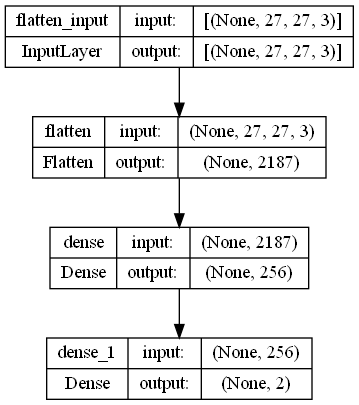

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [11]:
model.compile(optimizer='SGD', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [12]:
X_train['isCancerous'] = X_train['isCancerous'].astype('str')
X_val['isCancerous'] = X_val['isCancerous'].astype('str')

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_image = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_image.flow_from_dataframe(
        dataframe=X_train,
        directory='../../data/raw/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_image.flow_from_dataframe(
        dataframe=X_val,
        directory='../../data/raw/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [14]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

In [15]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

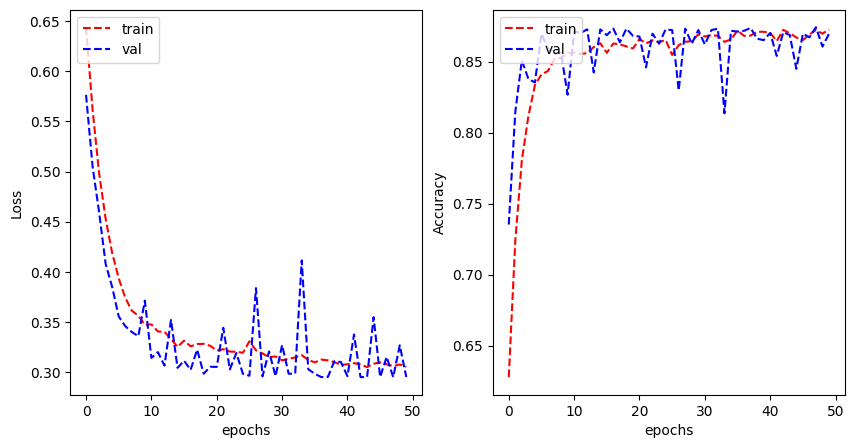

In [16]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Regularisation with Lasso

In [17]:
reg_lambda = 0.01

model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=input_dim),
    tf.keras.layers.Dense(hidden_layer_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(output_classes, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [18]:
model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [19]:
history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

C:\Users\User\AppData\Local\Temp\ipykernel_2080\4290883935.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_reg = model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=150, verbose=0)


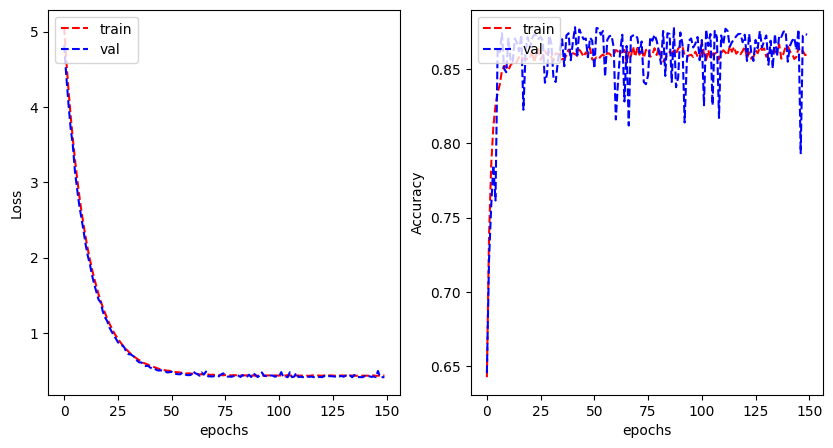

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_reg.history['loss'], 'r--')
plt.plot(history_reg.history['val_loss'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_reg.history['categorical_accuracy'], 'r--')
plt.plot(history_reg.history['val_categorical_accuracy'], 'b--')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.show()

In [21]:
model.save("base_model")

INFO:tensorflow:Assets written to: base_model\assets


INFO:tensorflow:Assets written to: base_model\assets


Things to get:
- Desired metrics
- accuracy score for best performance

In this case, we want to achieve the least false negative.

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [23]:
X_test['isCancerous'] = X_test['isCancerous'].astype('str')

test_image = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_generator = test_image.flow_from_dataframe(
        dataframe=X_test,
        directory='../../data/raw/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_pred = model.predict(test_generator)

Found 1980 validated image filenames belonging to 2 classes.


I am stuck from this point, trying to get the classification going.

In [40]:

# test_pred = model.predict(test_generator)

# classes = ["non-Cancerous", "Cancerous"]

# cm = confusion_matrix(X_test['isCancerous'], test_pred, labels = classes)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classes)
# disp.plot()
# plt.show()

In [42]:
X_test['isCancerous']

7292    1
6128    0
5446    1
2061    0
8706    0
       ..
8552    0
9562    0
3925    1
4555    0
6494    1
Name: isCancerous, Length: 1980, dtype: object

In [43]:
test_pred

array([[ 2.5793536 , -1.6108035 ],
       [ 2.4796627 , -1.6259711 ],
       [-0.7147221 ,  1.5273956 ],
       ...,
       [ 2.8787344 , -2.003954  ],
       [ 0.99127686, -0.10879196],
       [ 1.4532948 , -0.6916151 ]], dtype=float32)

In [44]:
test_pred.shape

(1980, 2)

In [41]:
m = tf.keras.metrics.FalsePositives()
m.update_state(X_test['isCancerous'], test_pred)

UnimplementedError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cast string to float is not supported [Op:Cast]